# Import Libraries

In [1]:
import pickle
import umap
from tqdm import tqdm
import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from skimage.metrics import structural_similarity
from skimage.registration import phase_cross_correlation

%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd
from IPython.display import Image, display

pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings('ignore') 

/home/yuxiao/anaconda3/envs/stamp/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yuxiao/anaconda3/envs/stamp/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yuxiao/anaconda3/envs/stamp/lib/python3.9/site-packages/umap/distanc

In [ ]:
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype("uint8")
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

def  try_convert_val(value):
     try:
         return value["jibo"]
     except:
         return np.nan

# Read Features

In [17]:
df = pd.read_json("/home/yuxiao/nii_project/dataset/1.json")
df["char"] = df["data"].apply(lambda x: x["char"])
df["url"] = df["data"].apply(lambda x: "" + x["url"][28:])
df["image_file"] = df["url"].apply(lambda x: x[10:])
df["jibo"] = df["data"].apply(lambda x: try_convert_val(x))
df = df[["char", "url", "image_file", "jibo"]]

# df_count = (
#     df.groupby("char").count().sort_values(by=["data"], ascending=False)[["data"]]
# )

with open(
    "/home/yuxiao/nii_project/dataset/feature.pkl", "rb"
) as handle:
    data = pickle.load(handle)

features = pd.DataFrame(data.items(), columns=["image_file", "features"])
features.features = features.features.apply(lambda x: x[0])

df = pd.merge(df, features, on="image_file")
df["index"] = df.index
df

,char,url,image_file,jibo,features,index
0,その,dataset/1/0_001_0_1.jpg,0_001_0_1.jpg,曽能,"[0.0, 0.17923507, 0.6853925, 0.0, 0.64076066, ...",0
1,子,dataset/1/1_001_0_1.jpg,1_001_0_1.jpg,子,"[0.0, 0.06490883, 0.7553527, 0.0, 1.8801092, 0...",1
2,むまこ,dataset/1/2_001_0_1.jpg,2_001_0_1.jpg,武末己,"[0.0, 0.0, 1.0507238, 0.0, 0.0, 0.0, 0.9604026...",2
3,まては,dataset/1/3_001_0_1.jpg,3_001_0_1.jpg,末天盤,"[0.0, 0.0, 1.3613088, 0.0, 0.0, 0.0, 1.392829,...",3
4,はふれ,dataset/1/4_001_0_1.jpg,4_001_0_1.jpg,者不礼,"[1.0408883, 0.22247303, 0.0, 0.0, 0.0, 0.0, 0....",4
...,...,...,...,...,...,...
36864,国の,dataset/1/36875_001_9_1.jpg,36875_001_9_1.jpg,国能,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3766456, 0.0,...",36864
36865,博,dataset/1/36876_001_9_1.jpg,36876_001_9_1.jpg,博,"[0.5601986, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5675535...",36865
36866,士,dataset/1/36877_001_9_1.jpg,36877_001_9_1.jpg,士,"[2.2734532, 0.0, 2.9041276, 0.0, 0.0, 1.136055...",36866
36867,共,dataset/1/36878_001_9_1.jpg,36878_001_9_1.jpg,共,"[0.50920856, 0.6307348, 0.06636953, 0.0, 0.0, ...",36867


In [18]:
char_list = df.char.unique()
char_list

array(['その', '子', 'むまこ', ..., 'もいにし', '篇', '博'], dtype=object)

# Dimensionality Reduction

## TSNE + Kmeans

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000)
for char in tqdm(char_list):
    if len(df[df["char"] == char]) > 1:
        tsne_results = tsne.fit_transform(list(df[df["char"] == char].features))
        clustering = DBSCAN(eps=1, min_samples=2).fit(tsne_results)
        df.loc[df["char"] == char, "label"] = np.array(clustering.labels_, dtype=str)
        df.loc[df["char"] == char, "label"] = df.loc[
            df["char"] == char, "char"
        ].str.cat(df.loc[df["char"] == char, "label"], sep="_")
        df.loc[df["char"] == char, "x"] = tsne_results[:, 0]
        df.loc[df["char"] == char, "y"] = tsne_results[:, 1]
    else:
        df.loc[df["char"] == char, "label"] = df.loc[df["char"] == char, "char"]

In [ ]:
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(list(df[df["char"] == "に"].features))

In [ ]:
clustering = DBSCAN(eps=3, min_samples=2).fit(tsne_results)

In [ ]:
plt.figure(figsize=(20, 12))
plt.scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    s=10,
    c=clustering.labels_,
    cmap="rainbow",
)

In [ ]:
for url in df[df["char"] == "に"][clustering.labels_ == 8].image_file:
    display(Image(filename="/Users/liyuxiao/Downloads/nii_project/dataset/1/" + url))

## UMAP+DBSCAN

In [5]:
for char in tqdm(char_list):
    if len(df[df["char"] == char]) > 10:
        standard_embedding = umap.UMAP(
            n_neighbors=5, min_dist=0.0, n_components=2, random_state=42
        ).fit_transform(list(df[df["char"] == char].features))

        clustering = DBSCAN(eps=2, min_samples=5).fit(standard_embedding)
        df.loc[df["char"] == char, "label"] = np.array(clustering.labels_, dtype=str)
        df.loc[df["char"] == char, "label"] = df.loc[
            df["char"] == char, "char"
        ].str.cat(df.loc[df["char"] == char, "label"], sep="_")
        df.loc[df["char"] == char, "x"] = standard_embedding[:, 0]
        df.loc[df["char"] == char, "y"] = standard_embedding[:, 1]
    else:
        df.loc[df["char"] == char, "label"] = df.loc[df["char"] == char, "char"]
        df.loc[df["char"] == char, "x"] = np.random.rand(len(df[df["char"] == char]), 1)
        df.loc[df["char"] == char, "y"] = np.random.rand(len(df[df["char"] == char]), 1)

100%|██████████| 3757/3757 [07:35<00:00,  8.26it/s]


In [19]:
df.groupby("char").size().sort_values(ascending=False).head(50)

char
の     1536
に     1363
を     1043
は     1000
て      925
と      758
人      509
も      503
か      445
き      395
事      335
し      317
なり     301
い      297
す      287
たる     257
さ      247
や      236
み      228
ま      221
く      214
こ      193
ける     183
こそ     182
心      175
つ      172
ぬ      171
な      168
あ      166
う      166
へ      165
そ      161
あり     150
物      147
た      146
め      145
なる     144
けり     135
れ      127
より     127
たり     122
ひ      117
いふ     115
にて     114
け      113
御      110
なと     110
こと     109
なく     108
には     107
dtype: int64

In [7]:
df[df["char"] == "み"].groupby("jibo").size()

jibo
三     118
三　      1
美      88
見      21
dtype: int64

In [16]:
from IPython.display import Image, display

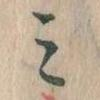

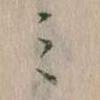

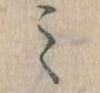

-----


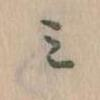

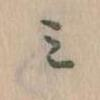

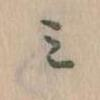

-----


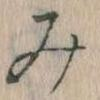

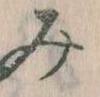

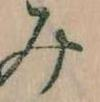

-----


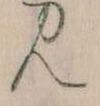

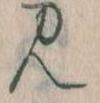

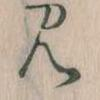

-----


In [66]:
for jibo in df[df["char"] == "み"].groupby("jibo"):
    display(Image(filename="../"+jibo[1].sample(3,replace=True).iloc[0].url))
    display(Image(filename="../"+jibo[1].sample(3,replace=True).iloc[2].url))
    display(Image(filename="../"+jibo[1].sample(3,replace=True).iloc[1].url))
    print("-----")

In [12]:
df = df[["char", "url", "image_file", "jibo", "features", "label", "x", "y"]]

In [2]:
df = pd.read_csv("/home/yuxiao/nii_project/dataset/df/feature_data.csv")

In [7]:
df[df["char"] == char].groupby("jibo").size()

jibo
八    708
波     92
盤    154
者     45
葉      1
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


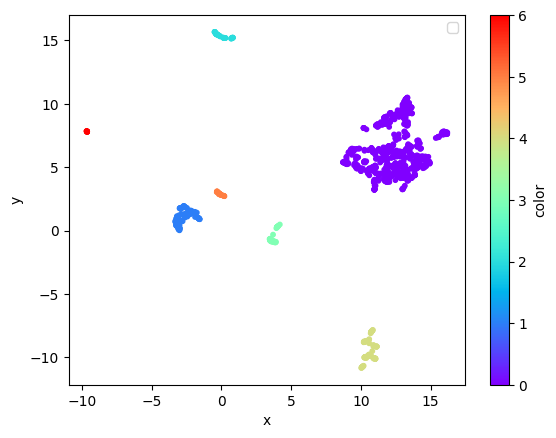

In [4]:
char = "は"
color_dict = {}
for idx, element in enumerate(np.unique(df.loc[df["char"] == char].label)):
    color_dict[element] = idx
df["color"] = df.loc[df["char"] == char, "label"].map(color_dict)

ax = df.plot.scatter(x="x", y="y", s=10, c="color", cmap="rainbow")
ax.legend()

In [14]:
df.to_csv("../dataset/df/feature_data.csv", index=False)

In [20]:
df = pd.read_csv("../dataset/df/feature_data.csv")

### NN Search

In [ ]:
knn = NearestNeighbors(n_neighbors=11)
# knn.fit(df.loc[df["char"] == char][["x", "y"]].values)

# nei = knn.kneighbors(
#     df.loc[df["char"] == char].iloc[467][["x", "y"]].values.reshape(1, -1),
#     return_distance=False,
# )
# for url in df.loc[df["char"] == char].iloc[nei[0]].image_file:
#     display(Image(filename="/Users/liyuxiao/Downloads/nii_project/dataset/1/" + url))

### SIFT

In [ ]:
# reading image
img1 = cv2.imread("../dataset/1/" + df.loc[df["char"] == char].iloc[467].image_file)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)

img_1 = cv2.drawKeypoints(gray1, keypoints_1, img1)
plt.imshow(img_1)
nei = knn.kneighbors(
    df.loc[df["char"] == char].iloc[467][["x", "y"]].values.reshape(1, -1),
    return_distance=False,
)
for i in nei[0][3:]:
    # Load images
    img_2 = cv2.imread("../dataset/1/" + df.loc[df["char"] == char].iloc[i].image_file)
    gray2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

    # keypoints
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_2, descriptors_2 = sift.detectAndCompute(img_2, None)

    img_2 = cv2.drawKeypoints(gray2, keypoints_2, img_2)
    plt.imshow(img_2)

In [ ]:
def get_similarity_from_desc(approach, search_desc, idx_desc):
    if approach == "sift" or approach == "orb_sift":
        # BFMatcher with euclidean distance
        bf = cv2.BFMatcher()
    else:
        # BFMatcher with hamming distance
        bf = cv2.BFMatcher(cv.NORM_HAMMING)
    matches = bf.match(search_desc, idx_desc)
    # Distances between search and index features that match
    distances = [m.distance for m in matches]
    # Distance between search and index images
    distance = sum(distances) / len(distances)
    # If distance == 0 -> similarity = 1
    similarity = 1 / (1 + distance)
    return similarity

### phase_cross_correlation 

In [27]:
df["score"] = 0
df["index"] = df.index

In [30]:
for char in tqdm(np.unique(df.char)):
    if len(df.loc[df["char"] == char]) >= 11:
        # Find nearest neighbors
        knn = NearestNeighbors(n_neighbors=11)
    else:
        knn = NearestNeighbors(n_neighbors=len(df.loc[df["char"] == char]))
    knn.fit(df.loc[df["char"] == char][["x", "y"]].values)
    for idx, row in df.loc[df["char"] == char].iterrows():
        # Load Ref images
        imgRef = cv2.imread("/home/yuxiao/nii_project/dataset/2/" + row["image_file"])
        temp = 0
        nei = knn.kneighbors(
            row[["x", "y"]].values.reshape(1, -1),
            return_distance=False,
        )
        for i in nei[0][1:]:
            # Load Neighbor images
            imgTest = cv2.imread(
                "/home/yuxiao/nii_project/dataset/2/"
                + df.loc[df["char"] == char].iloc[i].image_file
            )

            # Convert to grayscale.
            imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
            imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)

            height1, width1 = imgRef_grey.shape
            height2, width2 = imgTest_grey.shape

            height_max = max(height1, height2)
            width_max = max(width1, width2)

            # Pad the images to same size
            imgRef_grey = cv2.copyMakeBorder(
                imgRef_grey,
                height_max - height1,
                0,
                width_max - width1,
                0,
                cv2.BORDER_REPLICATE,
            )
            imgTest_grey = cv2.copyMakeBorder(
                imgTest_grey,
                height_max - height2,
                0,
                width_max - width2,
                0,
                cv2.BORDER_REPLICATE,
            )

            # pixel precision first
            shift, _, _ = phase_cross_correlation(imgRef_grey, imgTest_grey)
            # print(f"Detected subpixel offset (y, x): {shift}")

            height_offset, weith_offset = int(shift[0]), int(shift[1])

            # Compute Similarity
            if height_offset > 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, weith_offset:],
                    imgTest_grey[:-height_offset, :-weith_offset],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset > 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, :weith_offset],
                    imgTest_grey[:-height_offset, -weith_offset:],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, weith_offset:],
                    imgTest_grey[-height_offset:, :-weith_offset],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, :weith_offset],
                    imgTest_grey[-height_offset:, -weith_offset:],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset == 0 and weith_offset > 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:, weith_offset:],
                    imgTest_grey[:, :-weith_offset],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset == 0 and weith_offset < 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:, :weith_offset],
                    imgTest_grey[:, -weith_offset:],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset > 0 and weith_offset == 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[height_offset:, :],
                    imgTest_grey[:-height_offset, :],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            elif height_offset < 0 and weith_offset == 0:
                (score, diff) = structural_similarity(
                    imgRef_grey[:height_offset, :],
                    imgTest_grey[-height_offset:, :],
                    full=True,
                )
                # print("Image Structure Similarity: {:.4f}%".format(score * 100))
            if score > temp:
                df.at[idx, "NN"] = int(df.loc[df["char"] == char].iloc[i]["index"])
                df.at[idx, "score"] = score
        # print("---------")

  0%|          | 0/3757 [00:00<?, ?it/s]

100%|██████████| 3757/3757 [1:08:53<00:00,  1.10s/it] 


In [32]:
df.to_csv("../dataset/df/feature_data.csv", index=False)

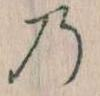

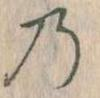

--------


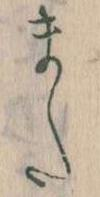

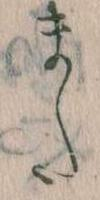

--------


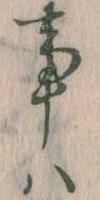

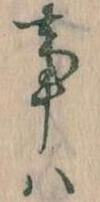

--------


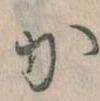

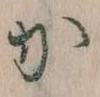

--------


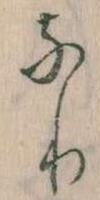

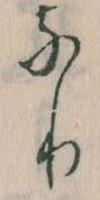

--------


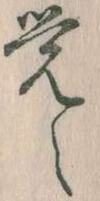

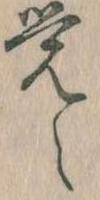

--------


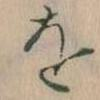

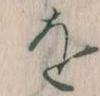

--------


In [35]:
for idx, row in df.sample(10).iterrows():
    if row["score"] > 0.8 and not np.isnan(row["NN"]):
        display(Image(filename=f"../dataset/1/{row.image_file}"))
        display(Image(filename=f"../dataset/1/{df.iloc[int(row.NN)].image_file}"))

        print("--------")

In [36]:
df = pd.read_csv("/home/yuxiao/nii_project/dataset/df/feature_data.csv")

### Contrastive

In [38]:
df_pos = df[df["score"] > 0.9][["image_file", "NN"]]
df_pos["Pos"] = df_pos["NN"].apply(lambda x: df.iloc[int(x)]["image_file"])
df_pos["label"] = 0
df_pos = df_pos[["image_file", "Pos", "label"]].rename(
    columns={"image_file": "image1", "Pos": "image2"}
)

df_neg = df.sample(3 * len(df_pos))

anchor, negative = [], []
for idx, row in df_neg[df_neg["label"].str.contains("_")].iterrows():
    if len(df_neg[df_neg["label"] == row.label]) >= 20:
        sampled = df_neg[df_neg["label"] == row.label].sample(20, replace=True)
        sampled["dist"] = sampled.apply(
            lambda x: (x["x"] - row["x"]) ** 2 + (x["y"] - row["y"]) ** 2, axis=1
        )
        # if ((sampled["index"] != row["index"]) & (sampled["index"] != int(row.NN))).all():
        anchor.append(row["image_file"])
        negative.append(
            sampled[sampled.dist == sampled.dist.max()]["image_file"].values[0]
        )

df_neg = pd.DataFrame(
    list(zip(anchor, negative, [1] * len(anchor))),
    columns=["image1", "image2", "label"],
)

df_csv = pd.concat([df_neg, df_pos], ignore_index=True)

In [39]:
df_csv.groupby("label").size()

label
0    6976
1    8332
dtype: int64

In [ ]:
df_train, df_test = train_test_split(df_csv, test_size=0.2, random_state=1)
# df_train, df_val = train_test_split(
#     df_train, test_size=0.25, random_state=1
# )  # 0.25 x 0.8 = 0.2

In [ ]:
df_train.to_csv("../siamese/data/train_data_c.csv", index=False)
df_test.to_csv("../siamese/data/test_data_c.csv", index=False)
# df_val.to_csv("../siamese/data/val_data_c.csv", index=False)

### Triplet

In [ ]:
df_pos = df[df["score"] > 0.9]

anchor, negative = [], []
for idx, row in df_pos[df_pos["label"].str.contains("_")].iterrows():
    if len(df_pos[df_pos["label"] == row.label]) >= 10:
        sampled = df_pos[df_pos["label"] == row.label].sample(10, replace=True)
        sampled["dist"] = sampled.apply(
            lambda x: (x["x"] - row["x"]) ** 2 + (x["y"] - row["y"]) ** 2, axis=1
        )
        # if ((sampled["index"] != row["index"]) & (sampled["index"] != int(row.NN))).all():
        anchor.append(row["image_file"])
        negative.append(
            sampled[sampled.dist == sampled.dist.max()]["image_file"].values[0]
        )

df_neg = pd.DataFrame(
    list(zip(anchor, negative)),
    columns=["anchor", "negative"],
)

df_pos = df_pos[["image_file", "NN"]]
df_pos["Pos"] = df_pos["NN"].apply(lambda x: df.iloc[int(x)]["image_file"])
df_pos["label"] = 0
df_pos = df_pos[["image_file", "Pos"]].rename(
    columns={"image_file": "anchor", "Pos": "positive"}
)

df_csv = pd.merge(df_neg, df_pos, on="anchor")

In [ ]:
df_csv

In [ ]:
df_train, df_test = train_test_split(df_csv, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(
    df_train, test_size=0.25, random_state=1
)  # 0.25 x 0.8 = 0.2

In [ ]:
df_train.to_csv("../siamese/data/train_data_t.csv", index=False)
df_test.to_csv("../siamese/data/test_data_t.csv", index=False)
df_val.to_csv("../siamese/data/val_data_t.csv", index=False)

### Edge Detection

In [ ]:
# Load images
imgRef = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
    + df.loc[df["char"] == char].iloc[22].image_file
)
imgRef = cv2.Canny(imgRef, 100, 200)

nei = knn.kneighbors(
    df.loc[df["char"] == char].iloc[22][["x", "y"]].values.reshape(1, -1),
    return_distance=False,
)
for i in nei[0][1:]:
    # Load images
    imgTest = cv2.imread(
        "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
        + df.loc[df["char"] == char].iloc[i].image_file
    )
    imgTest = cv2.Canny(imgTest, 100, 200)

    height, width = imgTest.shape

    # Configure ORB feature detector Algorithm with 1000 features.
    orb_detector = cv2.ORB_create(1000)

    # Extract key points and descriptors for both images
    (kpsA, descsA) = orb_detector.detectAndCompute(imgTest, None)
    (kpsB, descsB) = orb_detector.detectAndCompute(imgRef, None)

    # Display keypoints for reference image in green color
    imgKp_Ref = cv2.drawKeypoints(imgRef, kpsA, 0, (0, 222, 0), None)

    cv2_imshow(imgKp_Ref)
    plt.show()

    # Match features between two images using Brute Force matcher with Hamming distance
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)

    # Match the two sets of descriptors.
    matches = matcher.match(descsA, descsB, None)

    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x: x.distance)
    # keep only the top matches
    keep = 1
    matches = matches[:keep]
    # check to see if we should visualize the matched keypoints

    matchedVis = cv2.drawMatches(imgTest, kpsA, imgRef, kpsB, matches, None)
    cv2_imshow(matchedVis)
    plt.show()

    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for i, m in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    # compute the homography matrix between the two sets of matched
    # points
    # (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    H = np.float32(
        [[1, 0, (ptsB - ptsA).mean(axis=0)[0]], [0, 1, (ptsB - ptsA).mean(axis=0)[1]]]
    )
    if not np.isnan(H[0, 2]) and not np.isnan(H[1, 2]):
        (h, w) = imgRef.shape[:2]
        aligned = cv2.warpAffine(imgTest, H, (w, h))
        h_t = abs(math.ceil(H[0, 2]))
        w_t = abs(math.ceil(H[1, 2]))

        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef)
        cv2_imshow(imgTest, alpha=0.8)
        plt.show()

        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef)
        cv2_imshow(aligned, alpha=0.8)
        plt.show()

        # Compute SSIM between the two images
        if w_t != 0 and h_t != 0:
            (score, diff) = structural_similarity(
                imgRef[w_t:-w_t, h_t:-h_t], aligned[w_t:-w_t, h_t:-h_t], full=True
            )
        elif w_t == 0:
            (score, diff) = structural_similarity(
                imgRef[:, h_t:-h_t], aligned[:, h_t:-h_t], full=True
            )
        else:
            (score, diff) = structural_similarity(
                imgRef[w_t:-w_t:, :], aligned[w_t:-w_t:, :], full=True
            )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
        print(
            "Image self-defined Similarity: {:.4f}%".format(
                get_similarity_from_desc("sift", descsA, descsB) * 100
            )
        )

### SIFT features match

In [ ]:
# Load images
imgRef = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
    + df.loc[df["char"] == char].iloc[22].image_file
)
nei = knn.kneighbors(
    df.loc[df["char"] == char].iloc[22][["x", "y"]].values.reshape(1, -1),
    return_distance=False,
)
for i in nei[0][1:]:
    # Load images
    imgTest = cv2.imread(
        "/Users/liyuxiao/Downloads/nii_project/dataset/1/"
        + df.loc[df["char"] == char].iloc[i].image_file
    )

    # Convert to grayscale.
    imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
    imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)
    height1, width1 = imgRef_grey.shape
    height2, width2 = imgTest_grey.shape

    height_max = max(height1, height2)
    width_max = max(width1, width2)

    imgRef_grey = cv2.copyMakeBorder(
        imgRef_grey,
        height_max - height1,
        0,
        width_max - width1,
        0,
        cv2.BORDER_REPLICATE,
    )
    imgTest_grey = cv2.copyMakeBorder(
        imgTest_grey,
        height_max - height2,
        0,
        width_max - width2,
        0,
        cv2.BORDER_REPLICATE,
    )

    # Configure ORB feature detector Algorithm with 1000 features.
    orb_detector = cv2.ORB_create(1000)

    # Extract key points and descriptors for both images
    (kpsA, descsA) = orb_detector.detectAndCompute(imgTest_grey, None)
    (kpsB, descsB) = orb_detector.detectAndCompute(imgRef_grey, None)

    # Display keypoints for reference image in green color
    imgKp_Ref = cv2.drawKeypoints(imgRef_grey, kpsA, 0, (0, 222, 0), None)

    cv2_imshow(imgKp_Ref)
    plt.show()

    # Match features between two images using Brute Force matcher with Hamming distance
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)

    # Match the two sets of descriptors.
    matches = matcher.match(descsA, descsB, None)

    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x: x.distance)
    # keep only the top matches
    keep = 1
    matches = matches[:keep]
    # check to see if we should visualize the matched keypoints

    matchedVis = cv2.drawMatches(imgTest_grey, kpsA, imgRef_grey, kpsB, matches, None)
    cv2_imshow(matchedVis)
    plt.show()

    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for i, m in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    # compute the homography matrix between the two sets of matched
    # points
    # (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    H = np.float32(
        [[1, 0, (ptsB - ptsA).mean(axis=0)[0]], [0, 1, (ptsB - ptsA).mean(axis=0)[1]]]
    )
    if not np.isnan(H[0, 2]) and not np.isnan(H[1, 2]):
        (h, w) = imgRef_grey.shape[:2]
        aligned = cv2.warpAffine(imgTest_grey, H, (w, h))
        h_t = abs(math.ceil(H[0, 2]))
        w_t = abs(math.ceil(H[1, 2]))

        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey)
        cv2_imshow(imgTest_grey, alpha=0.8)
        plt.show()

        fig = plt.figure(frameon=False)
        cv2_imshow(imgRef_grey)
        cv2_imshow(aligned, alpha=0.8)
        plt.show()

        # Compute SSIM between the two images
        if w_t != 0 and h_t != 0:
            (score, diff) = structural_similarity(
                imgRef_grey[w_t:-w_t, h_t:-h_t], aligned[w_t:-w_t, h_t:-h_t], full=True
            )
        elif w_t == 0:
            (score, diff) = structural_similarity(
                imgRef_grey[:, h_t:-h_t], aligned[:, h_t:-h_t], full=True
            )
        else:
            (score, diff) = structural_similarity(
                imgRef_grey[w_t:-w_t:, :], aligned[w_t:-w_t:, :], full=True
            )
        print("Image Structure Similarity: {:.4f}%".format(score * 100))
        print(
            "Image self-defined Similarity: {:.4f}%".format(
                get_similarity_from_desc("sift", descsA, descsB) * 100
            )
        )

In [ ]:
for url in df[df["char"] == "よ"][clustering.labels_ == 3].image_file:
    display(Image(filename="/Users/liyuxiao/Downloads/nii_project/dataset/1/" + url))

In [ ]:
standard_embedding = umap.UMAP(
    n_neighbors=3, min_dist=0.0, n_components=2, random_state=42
).fit_transform(list(features.features))

In [ ]:
clustering = DBSCAN(eps=0.05, min_samples=2).fit(standard_embedding)
clustering.labels_

In [ ]:
counter = collections.Counter(clustering.labels_)

counter.most_common()

In [ ]:
plt.figure(figsize=(20, 12))
plt.scatter(
    standard_embedding[:, 0],
    standard_embedding[:, 1],
    s=0.1,
    c=clustering.labels_,
    cmap="Spectral",
)
plt.show()

In [ ]:
x = 616
# Load images
before = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + features[clustering.labels_ == x].iloc[0].image_file
)
after = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + features[clustering.labels_ == x].iloc[1].image_file
)

# Convert images to grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Compute SSIM between the two images
(score, diff) = structural_similarity(before_gray, after_gray, full=True)
print("Image Similarity: {:.4f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1]
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")
diff_box = cv2.merge([diff, diff, diff])

# Threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

mask = np.zeros(before.shape, dtype="uint8")
filled_after = after.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 40:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(before, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(after, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.rectangle(diff_box, (x, y), (x + w, y + h), (36, 255, 12), 2)
        cv2.drawContours(mask, [c], 0, (255, 255, 255), -1)
        cv2.drawContours(filled_after, [c], 0, (0, 255, 0), -1)

In [ ]:
cv2_imshow(before)

In [ ]:
cv2_imshow(after)

In [ ]:
cv2_imshow(diff)

In [ ]:
cv2_imshow(diff_box)

In [ ]:
cv2_imshow(mask)

In [ ]:
cv2_imshow(filled_after)

### Registration

In [ ]:
nei

In [ ]:
# Load images
imgTest = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + df.loc[df["char"] == "に"].iloc[10].image_file
)
imgRef = cv2.imread(
    "/Users/liyuxiao/Downloads/nii_project/dataset/2/"
    + df.loc[df["char"] == "に"].iloc[242].image_file
)

# Convert to grayscale.
imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)
height, width = imgTest_grey.shape

# Configure ORB feature detector Algorithm with 1000 features.
orb_detector = cv2.ORB_create(1000)

# Extract key points and descriptors for both images
(kpsA, descsA) = orb_detector.detectAndCompute(imgTest, None)
(kpsB, descsB) = orb_detector.detectAndCompute(imgRef, None)

# Display keypoints for reference image in green color
imgKp_Ref = cv2.drawKeypoints(imgRef, kpsA, 0, (0, 222, 0), None)

# cv2_imshow(imgKp_Ref)
# plt.show()

# Match features between two images using Brute Force matcher with Hamming distance
# matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# match the features
method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
matcher = cv2.DescriptorMatcher_create(method)

# Match the two sets of descriptors.
matches = matcher.match(descsA, descsB, None)

# sort the matches by their distance (the smaller the distance,
# the "more similar" the features are)
matches = sorted(matches, key=lambda x: x.distance)
# keep only the top matches
keep = int(len(matches) * 0.5)
matches = matches[:keep]
# check to see if we should visualize the matched keypoints

matchedVis = cv2.drawMatches(imgTest, kpsA, imgRef, kpsB, matches, None)
# cv2_imshow(matchedVis)
# plt.show()

# allocate memory for the keypoints (x, y)-coordinates from the
# top matches -- we'll use these coordinates to compute our
# homography matrix
ptsA = np.zeros((len(matches), 2), dtype="float")
ptsB = np.zeros((len(matches), 2), dtype="float")
# loop over the top matches
for i, m in enumerate(matches):
    # indicate that the two keypoints in the respective images
    # map to each other
    ptsA[i] = kpsA[m.queryIdx].pt
    ptsB[i] = kpsB[m.trainIdx].pt
# compute the homography matrix between the two sets of matched
# points
# (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
# use the homography matrix to align the images
H = np.float32(
    [[1, 0, (ptsB - ptsA).mean(axis=0)[0]], [0, 1, (ptsB - ptsA).mean(axis=0)[1]]]
)
(h, w) = imgRef.shape[:2]
aligned = cv2.warpAffine(imgTest, H, (w, h))

w_t = math.ceil(H[0, 2])
h_t = math.ceil(H[1, 2])

fig = plt.figure(frameon=False)
cv2_imshow(imgRef)
cv2_imshow(imgTest, alpha=0.5)
plt.show()

fig = plt.figure(frameon=False)
cv2_imshow(imgRef[h_t:, :w_t])
cv2_imshow(aligned[h_t:, :w_t], alpha=0.5)
plt.show()

# Compute SSIM between the two images
(score, diff) = structural_similarity(
    imgRef[h_t:, :w_t, 0], aligned[h_t:, :w_t, 0], full=True
)
print("Image Similarity: {:.4f}%".format(score * 100))